## Predictive modeling 
### Week 5: Regularization

In [ ]:
pip install pandas

In [ ]:
pip install sklearn

In [ ]:
pip install missingno

In [11]:
pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.7/233.7 kB 5.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade pip

  Using cached pip-22.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Note: you may need to restart the kernel to use updated packages.


In [12]:
# libraries
import pandas as pd # process dataframe
import numpy as np # scientific calculation
import seaborn as sns # visualization complete stastistics
import matplotlib.pyplot as plt # visualization
from sklearn.model_selection import train_test_split # train test split
from sklearn.preprocessing import MinMaxScaler # load scaler from sklearn
from sklearn.metrics import mean_squared_error # mse 
import missingno as msno # miss data visuals

import statsmodels.api as sm # statsmodels to build regression model

### 0. Dataset and some cleansing job

In [13]:
data = pd.read_csv('/Users/astroxjrk/Desktop/SEAC/Week6_python_ml/data/train-data.csv')
train_0 = data.drop(columns=['Unnamed: 0', 'New_Price'])

# strings to float transformation
train_0['Mileage'] = train_0['Mileage']\
    .str.replace('km/kg','').str.replace('kmpl','').astype(float)
train_0['Engine'] = train_0['Engine'].str.replace('CC','').astype(float)
train_0['Power'] = train_0['Power']\
    .str.replace('bhp','').str.replace('null', '0').fillna('0').astype(float)

# perform train test split 
X_all = train_0.drop(columns=['Price'])
y_all = train_0[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size=0.3, 
                                                    random_state=42)

# check data size 
print('Training set size: ', len(X_train)) # 70% of total data
print('Test set size: ', len(X_test)) # 30% of total data

Training set size:  4213
Test set size:  1806


### 1. Data processing

In [15]:
# Tukey's method
def tukeys_method(df, variable, q_range=1.5):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = q_range*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    outliers_poss = []
    
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_poss, inner_fence_le, inner_fence_ue 

#### 1.1 Training data

In [16]:
X_train_1 = X_train.copy()

# outliers removal 
outlier_indices, lower_limit, upper_limit = tukeys_method(y_train,'Price')
print('Lower limit: ', lower_limit)
print('Upper limit: ', upper_limit)

y_train_ul = y_train[y_train['Price']>upper_limit]
X_train_1 = X_train_1.drop(index=y_train_ul.index)
y_train_1 = y_train.drop(index=y_train_ul.index)

# missing data treatment
X_train_1['Mileage'] = X_train_1['Mileage'].fillna(X_train_1['Mileage'].mean())
X_train_1['Engine'] = X_train_1['Engine'].fillna(X_train_1['Engine'].median())
X_train_1['Seats'] = X_train_1['Seats'].fillna(int(X_train_1['Seats'].mode()))

# year transformation
X_train_1['Age'] = 2021 - X_train_1['Year']
X_train_1 = X_train_1.drop(columns=['Year'])

# categorical encoding
Location_enc = pd.get_dummies(X_train_1[['Location']])
Fuel_Type_enc = pd.get_dummies(X_train_1[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_train_1[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_train_1[['Owner_Type']])
X_train_1 = X_train_1.drop(columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_train_1 = pd.concat([X_train_1, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

# define data to be scaled 
x = X_train_1.drop(columns=['Name'])

scaler = MinMaxScaler() # instantiate the scaler
scaler_fit = scaler.fit(x) # fit the scaler on the data
x_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_train_1 = pd.DataFrame(x_sc, columns=x.columns)
X_train_1.info()

Lower limit:  -6.100000000000001
Upper limit:  19.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          3716 non-null   float64
 1   Mileage                    3716 non-null   float64
 2   Engine                     3716 non-null   float64
 3   Power                      3716 non-null   float64
 4   Seats                      3716 non-null   float64
 5   Age                        3716 non-null   float64
 6   Location_Ahmedabad         3716 non-null   float64
 7   Location_Bangalore         3716 non-null   float64
 8   Location_Chennai           3716 non-null   float64
 9   Location_Coimbatore        3716 non-null   float64
 10  Location_Delhi             3716 non-null   float64
 11  Location_Hyderabad         3716 non-null   float64
 12  Location_Jaipur            3716 non-null   float64
 

#### 1.2 Test data

In [21]:
X_test_1 = X_test.copy()
## missing data imputation
X_test_1['Mileage'] = X_test_1['Mileage'].fillna(X_test_1['Mileage'].mean())
X_test_1['Engine'] = X_test_1['Engine'].fillna(X_test_1['Engine'].median())
X_test_1['Seats'] = X_test_1['Seats'].fillna(int(X_test_1['Seats'].mode()))

## year to age transformation
X_test_1['Age'] = 2021 - X_test_1['Year']
X_test_1 = X_test_1.drop(columns=['Year'])

## categorical transformation
# encoding
Location_enc = pd.get_dummies(X_test_1[['Location']])
Fuel_Type_enc = pd.get_dummies(X_test_1[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_test_1[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_test_1[['Owner_Type']])

# adding them back the test data 
X_test_1 = X_test_1.drop(columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_test_1 = pd.concat([X_test_1, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

## min-max scaling
# define data to be scaled 
x = X_test_1.drop(columns=['Name'])
X_test_1_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_test_1 = pd.DataFrame(X_test_1_sc, columns=x.columns)
X_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          1806 non-null   float64
 1   Mileage                    1806 non-null   float64
 2   Engine                     1806 non-null   float64
 3   Power                      1806 non-null   float64
 4   Seats                      1806 non-null   float64
 5   Age                        1806 non-null   float64
 6   Location_Ahmedabad         1806 non-null   float64
 7   Location_Bangalore         1806 non-null   float64
 8   Location_Chennai           1806 non-null   float64
 9   Location_Coimbatore        1806 non-null   float64
 10  Location_Delhi             1806 non-null   float64
 11  Location_Hyderabad         1806 non-null   float64
 12  Location_Jaipur            1806 non-null   float64
 13  Location_Kochi             1806 non-null   float

### 2. Model fitting

In [22]:
# fit the model
X = sm.add_constant(X_train_1)
y = y_train_1.reset_index(drop=True)
lr = sm.OLS(y, X).fit()

display(lr.summary())

# predict the model
X = X_test_1
X = sm.add_constant(X)
tst_pred = lr.predict(X)
print('Test RMSE: ', mean_squared_error(y_test, tst_pred, squared=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     392.4
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:25:43   Log-Likelihood:                -8060.5
No. Observations:                3716   AIC:                         1.617e+04
Df Residuals:                    3691   BIC:                         1.633e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      4.385e+11   3.08e+12      0.142      0.887   -5.61e+12    6.48e+12
Kilometers_Driven            -6.0034      0.846     -7.096      0.000      -7.662      -4.345
Mileage                      -4.9481      0.462    -10.708      0.000      -5.854      -4.042
Engine                        8.4977      0.724     11.739      0.000       7.078       9.917
Power                        10.0871      0.575     17.533      0.000       8.959      11.215
Seats                        -1.5038      0.609     -2.469      0.014      -2.698      -0.310
Age                         -10.6862      0.306    -34.879      0.000     -11.287     -10.085
Location_Ahmedabad         2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Bangalore         2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Chennai           2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Coimbatore        2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Delhi             2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Hyderabad         2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Jaipur            2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Kochi             2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Kolkata           2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Mumbai            2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Location_Pune              2.755e+09   1.94e+10      0.142      0.887   -3.52e+10    4.07e+10
Fuel_Type_CNG              6.427e+11   4.52e+12      0.142      0.887   -8.22e+12     9.5e+12
Fuel_Type_Diesel           6.427e+11   4.52e+12      0.142      0.887   -8.22e+12     9.5e+12
Fuel_Type_Electric         6.427e+11   4.52e+12      0.142      0.887   -8.22e+12     9.5e+12
Fuel_Type_LPG              6.427e+11   4.52e+12      0.142      0.887   -8.22e+12     9.5e+12
Fuel_Type_Petrol           6.427e+11   4.52e+12      0.142      0.887   -8.22e+12     9.5e+12
Transmission_Automatic    -7.738e+11   5.44e+12     -0.142      0.887   -1.14e+13    9.89e+12
Transmission_Manual       -7.738e+11   5.44e+12     -0.142      0.887   -1.14e+13    9.89e+12
Owner_Type_First            -3.1e+11   2.18e+12     -0.142      0.887   -4.58e+12    3.96e+12
Owner_Type_Fourth & Above   -3.1e+11   2.18e+12     -0.142      0.887   -4.58e+12    3.96e+12
Owner_Type_Second           -3.1e+11   2.18e+12     -0.142      0.887   -4.58e+12    3.96e+12
Owner_Type_Third            -3.1e+11   2.18e+12     -0.142      0.887   -4.58e+12    3.96e+12
===========================================================================

Test RMSE:  8.42987640686407


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


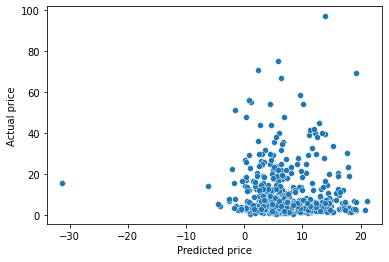

In [23]:
# prediction plot
sns.scatterplot(tst_pred, y_test['Price'])
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.show();

### 3. Model fitting improvement 
- Changing the outlier cutoff to be 3 IQR
- Log scaling on the target variable
- Recode cities into two zones high and low GDP

In [24]:
high_gdp = ['Coimbatore', 'Mumbai', 'Pune']
medium_gdp = ['Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad']
low_gdp = ['Jaipur', 'Kochi', 'Kolkata']

In [25]:
X_train_2 = X_train.copy()

# outliers removal 
outlier_indices, lower_limit, upper_limit = tukeys_method(y_train, 'Price', 3.0)
print('Lower limit: ', lower_limit)
print('Upper limit: ', upper_limit)

y_train_ul = y_train[y_train['Price']>upper_limit]
X_train_2 = X_train_2.drop(index=y_train_ul.index)
y_train_2 = y_train.drop(index=y_train_ul.index)

# missing data treatment
X_train_2['Mileage'] = X_train_2['Mileage'].fillna(X_train_2['Mileage'].mean())
X_train_2['Engine'] = X_train_2['Engine'].fillna(X_train_2['Engine'].median())
X_train_2['Seats'] = X_train_2['Seats'].fillna(int(X_train_2['Seats'].mode()))

# year transformation
X_train_2['Age'] = 2021 - X_train_2['Year']
X_train_2 = X_train_2.drop(columns=['Year'])

# categorical encoding
X_train_2['GDP'] = np.where(X_train_2['Location'].isin(high_gdp), 'High',
                   np.where(X_train_2['Location'].isin(medium_gdp), 'Medium', 'Low'))
Location_enc = pd.get_dummies(X_train_2[['GDP']])
Fuel_Type_enc = pd.get_dummies(X_train_2[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_train_2[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_train_2[['Owner_Type']])
X_train_2 = X_train_2.drop(columns=['Location', 'GDP', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_train_2 = pd.concat([X_train_2, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

# define data to be scaled 
x = X_train_2.drop(columns=['Name'])

scaler = MinMaxScaler() # instantiate the scaler
scaler_fit = scaler.fit(x) # fit the scaler on the data
x_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_train_2 = pd.DataFrame(x_sc, columns=x.columns)
X_train_2.info()

Lower limit:  -15.700000000000003
Upper limit:  29.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          3950 non-null   float64
 1   Mileage                    3950 non-null   float64
 2   Engine                     3950 non-null   float64
 3   Power                      3950 non-null   float64
 4   Seats                      3950 non-null   float64
 5   Age                        3950 non-null   float64
 6   GDP_High                   3950 non-null   float64
 7   GDP_Low                    3950 non-null   float64
 8   GDP_Medium                 3950 non-null   float64
 9   Fuel_Type_CNG              3950 non-null   float64
 10  Fuel_Type_Diesel           3950 non-null   float64
 11  Fuel_Type_Electric         3950 non-null   float64
 12  Fuel_Type_LPG              3950 non-null   float64


In [26]:
X_test_2 = X_test.copy()
## missing data imputation
X_test_2['Mileage'] = X_test_2['Mileage'].fillna(X_test_2['Mileage'].mean())
X_test_2['Engine'] = X_test_2['Engine'].fillna(X_test_2['Engine'].median())
X_test_2['Seats'] = X_test_2['Seats'].fillna(int(X_test_2['Seats'].mode()))

## year to age transformation
X_test_2['Age'] = 2021 - X_test_2['Year']
X_test_2 = X_test_2.drop(columns=['Year'])

## categorical transformation
# categorical encoding
X_test_2['GDP'] = np.where(X_test_2['Location'].isin(high_gdp), 'High',
                   np.where(X_test_2['Location'].isin(medium_gdp), 'Medium', 'Low'))
Location_enc = pd.get_dummies(X_test_2[['GDP']])
Fuel_Type_enc = pd.get_dummies(X_test_2[['Fuel_Type']])
Transmission_enc = pd.get_dummies(X_test_2[['Transmission']])
Owner_Type_enc = pd.get_dummies(X_test_2[['Owner_Type']])

# adding them back the test data 
X_test_2 = X_test_2.drop(columns=['Location', 'GDP', 'Fuel_Type', 'Transmission', 'Owner_Type'])
X_test_2 = pd.concat([X_test_2, Location_enc, Fuel_Type_enc, Transmission_enc, Owner_Type_enc], axis=1)

## min-max scaling
# define data to be scaled 
x = X_test_2.drop(columns=['Name'])
X_test_2_sc = scaler_fit.transform(x) # tranform the data using the fitted scaler
X_test_2 = pd.DataFrame(X_test_2_sc, columns=x.columns)
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Kilometers_Driven          1806 non-null   float64
 1   Mileage                    1806 non-null   float64
 2   Engine                     1806 non-null   float64
 3   Power                      1806 non-null   float64
 4   Seats                      1806 non-null   float64
 5   Age                        1806 non-null   float64
 6   GDP_High                   1806 non-null   float64
 7   GDP_Low                    1806 non-null   float64
 8   GDP_Medium                 1806 non-null   float64
 9   Fuel_Type_CNG              1806 non-null   float64
 10  Fuel_Type_Diesel           1806 non-null   float64
 11  Fuel_Type_Electric         1806 non-null   float64
 12  Fuel_Type_LPG              1806 non-null   float64
 13  Fuel_Type_Petrol           1806 non-null   float

In [27]:
# fit the model
X = sm.add_constant(X_train_2)
y = y_train_2.reset_index(drop=True)
y = np.log(y)
lr = sm.OLS(y, X).fit()

display(lr.summary())

lr_trn_pred = lr.predict(X)
lr_trn_pred = np.exp(lr_trn_pred)
print('Training RMSE: ', mean_squared_error(y_train_2, lr_trn_pred, squared=False))

# predict the model
x = X_test_2
X = sm.add_constant(x)
tst_pred = lr.predict(X)
print('Test RMSE: ', mean_squared_error(y_test, np.exp(tst_pred), squared=False))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1219.
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:35:22   Log-Likelihood:                -860.11
No. Observations:                3950   AIC:                             1754.
Df Residuals:                    3933   BIC:                             1861.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.244e+10   4.57e+11     -0.049      0.961   -9.19e+11    8.74e+11
Kilometers_Driven            -0.7313      0.115     -6.362      0.000      -0.957      -0.506
Mileage                      -0.7221      0.061    -11.766      0.000      -0.842      -0.602
Engine                        1.3882      0.103     13.436      0.000       1.186       1.591
Power                         2.2649      0.094     24.116      0.000       2.081       2.449
Seats                        -0.3110      0.084     -3.720      0.000      -0.475      -0.147
Age                          -2.5118      0.041    -61.473      0.000      -2.592      -2.432
GDP_High                  -5.213e+09   1.06e+11     -0.049      0.961   -2.13e+11    2.03e+11
GDP_Low                   -5.213e+09   1.06e+11     -0.049      0.961   -2.13e+11    2.03e+11
GDP_Medium                -5.213e+09   1.06e+11     -0.049      0.961   -2.13e+11    2.03e+11
Fuel_Type_CNG             -1.814e+10   3.69e+11     -0.049      0.961   -7.42e+11    7.06e+11
Fuel_Type_Diesel          -1.814e+10   3.69e+11     -0.049      0.961   -7.42e+11    7.06e+11
Fuel_Type_Electric        -1.814e+10   3.69e+11     -0.049      0.961   -7.42e+11    7.06e+11
Fuel_Type_LPG             -1.814e+10   3.69e+11     -0.049      0.961   -7.42e+11    7.06e+11
Fuel_Type_Petrol          -1.814e+10   3.69e+11     -0.049      0.961   -7.42e+11    7.06e+11
Transmission_Automatic     2.688e+10   5.48e+11      0.049      0.961   -1.05e+12     1.1e+12
Transmission_Manual        2.688e+10   5.48e+11      0.049      0.961   -1.05e+12     1.1e+12
Owner_Type_First           1.891e+10   3.85e+11      0.049      0.961   -7.36e+11    7.74e+11
Owner_Type_Fourth & Above  1.891e+10   3.85e+11      0.049      0.961   -7.36e+11    7.74e+11
Owner_Type_Second          1.891e+10   3.85e+11      0.049      0.961   -7.36e+11    7.74e+11
Owner_Type_Third           1.891e+10   3.85e+11      0.049      0.961   -7.36e+11    7.74e+11
==============================================================================
Omnibus:                      316.060   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1692.796
Skew:                          -0.155   Prob(JB):                         0.00
Kurtosis:                       6.192   Cond. No.                     3.85e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Training RMSE:  2.9240962072533256
Test RMSE:  6.158684751986951


<AxesSubplot:ylabel='Price'>

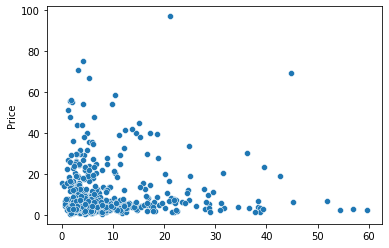

In [28]:
sns.scatterplot(x=np.exp(tst_pred), y=y_test['Price'])

### 4. Reduce overfitting - Regularization 
- Regularization means adding a term (penalty) to the regression formula. 
- Addtionally, regularization could be also used as a feature selection technique. 
- We will be demonstrating lasso regression, which adding the sum squared of coefficient to the model.

#### 4.1 Demo: Ridge regression with parameter tuning

In [ ]:
from sklearn.linear_model import Ridge

X = X_train_2
y = y_train_2.reset_index(drop=True)

model_ridge = Ridge(alpha=100)
model_ridge.fit(X, y)

train_pred = model_ridge.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

pred =  model_ridge.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

#### 4.2 Excerise: Lasso regression with parameter tuning
- import Lasso regression instead of Ridge
- Try fitting the model using alpha = 1 and alpha = 1000

In [ ]:
from sklearn.linear_model import Lasso

X = X_train_2
y = y_train_2.reset_index(drop=True)

model_lasso = Lasso(alpha=100)
model_lasso.fit(X, y)

train_pred = model_lasso.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

pred =  model_lasso.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))


#### 4.3 Demo: Cross validation for ridge regression

In [ ]:
from sklearn.linear_model import RidgeCV 

X = X_train_2
y = y_train_2.reset_index(drop=True)

# define cross-validation fold and parameter to be tuned
cv = 10
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 1000]

# define model
model = RidgeCV(alphas=alphas, cv=cv, normalize=False)

# fit model
model.fit(X, y)

# display lambda that produced the lowest test MSE
print(model.alpha_)

# report training error
train_pred = model.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

# report test error
pred =  model.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

In [ ]:
results = pd.DataFrame({'Feature Name': X_train_2.columns, 
                        'Coefficient': model.coef_.ravel()})
results.sort_values(by='Coefficient', ascending=False)

#### 4.4 Demo: Cross validation for lasso regression

In [ ]:
from sklearn.linear_model import LassoCV 

X = X_train_2
y = y_train_2.reset_index(drop=True)

# define cross-validation fold and parameter to be tuned
cv = 10
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000, 1000]

# define model
model = LassoCV(alphas=alphas, cv=cv, normalize=False)

# fit model
model.fit(X, y)

# display lambda that produced the lowest test MSE
print(model.alpha_)

# report training error
train_pred = model.predict(X_train_2)
print('Training RMSE: ', mean_squared_error(y_train_2, train_pred, squared=False))

# report test error
pred =  model.predict(X_test_2)
print('Test RMSE: ', mean_squared_error(y_test, pred, squared=False))

In [ ]:
results = pd.DataFrame({'Feature Name': X_train_2.columns, 
                        'Coefficient': model.coef_.ravel()})
results.sort_values(by='Coefficient', ascending=False)

In [ ]:
sns.regplot(x='Kilometers_Driven', y='Mileage', data=X_train_2)

In [ ]:
sns.regplot(x='Power', y='Mileage', data=X_train_2)